# Export of Azure Data Manager for Energy (ADME) data to Fabric

## External dependencies
ADME instance
Azure KeyVault to keep secret needed to connect to ADME 

## Setup of Delta Tables
A separate Notebook called "ADME setup and testing" has the code to create the delta lake tables for logging, data and last run info

## Setup variables for ADME
server - They URL to the ADME server. You can find this in the portal on the overview page of the ADME instance

Api URLs - These you do not have to change and can use the values already there.

data_partition - The name of the data partition you want to export from. Data partitions can be found in the Portal on the ADME instance. Find data partitions on the left side when you have opened the ADME instance.

legal_tag - This is the default value that will be put on the exported document if the original does not have a legal_tag

acl_viewer - This is the default value that will be put on the exported document if the original does not have a value

acl_owner - This is the default value that will be put on the exported document if the original does not have a value

authentication_mode - In this example we use "msal_interactive" See (insert link here) for more information

authority - "https://login.microsoftonline.com/xxxxx" where xxxx is your tenantid

scopes - ["xxxx/.default"], where xxxx is your client_id. NOTE this variable is a list and therefore it needs the square brackets even if it is only one value

client_id - this is the app id that was used to create the ADME instance

tenant_id - the tenant id. Search Tenant properties in Portal to find this value. This is the tenant where ADME resides.

redirect_uri - this value is set on the app used when creating the ADME instance. 

access_token_type - "keyvault", it is strongly recommended that you use a keyvault for the key to access AMDE

key_vault_name - the name of the key vault

secret_name - the name of the secret in the key vault

table_name - the name of the table you store data to in Fabric - put code at bottom of notebook

logging_table - the name of the table where logs will be stored

run_info_table - the name of the table where last run info is stored. This is used for delta loads since last run time

lakehouse_name - the name of the lakehouse where the delta tables will reside

## How to use the variables

**The variables are called with config["variable"], for example: config["server"]**






In [ ]:
import pandas as pd
import json

# Correct the JSON string format and load it
config_json = '''
{
    "server": "",
    "crs_catalog_url": "/api/crs/catalog/v2/",
    "crs_converter_url": "/api/crs/converter/v2/",
    "entitlements_url": "/api/entitlements/v2/",
    "file_url": "/api/file/v2/",
    "legal_url": "/api/legal/v1/",
    "schema_url": "/api/schema-service/v1/",
    "search_url": "/api/search/v2/",
    "storage_url": "/api/storage/v2/",
    "unit_url": "/api/unit/v3/",
    "workflow_url": "/api/workflow/v1/",
    "data_partition_id": "",
    "legal_tag": "legal_tag",
    "acl_viewer": "acl_viewer",
    "acl_owner": "acl_owner",
    "authentication_mode": "msal_interactive",
    "authority": "",
    "scopes": [""],
    "client_id": "",
    "tenant_id": "",
    "redirect_uri": "http://localhost:5050",
    "access_token_type" : "",
    "key_vault_name" : "",
    "secret_name" : "",
    "table_name" : "",
    "logging_table" : "",
    "run_info_table" : "",
    "lakehouse_name" : ""
}
'''

# Load the JSON string into a Python dictionary
config_dict = json.loads(config_json)

# Create a Series from the dictionary
config = pd.Series(config_dict)

#The number of documents in each batch. If you increase this you could see error messages about the load being too big
batch_size = 750

display(config)

# Spark settings
In the cell below you can define the spark environment. Go to **Workspaces - Choose your workspace and then Settings** in the upper right corner of the screen. Under Data Engineerin/Data Science you can find pool information. There you can see how many nodes you have availabe and can use in the settings below (maxExecutors, minExecutors, startExecutors).

## Other settings to consider 
The code will run fine without these, but they can be used to fine tune based on your needs


**spark.conf.set("spark.sql.parquet.vorder.enabled", "true")**

Enables the vectorized Parquet reader in Apache Spark. This setting enhances the performance of reading Parquet files by processing data in batches, taking advantage of the columnar storage format and reducing the overhead associated with row-by-row processing. This can lead to faster query execution and more efficient CPU usage, making it a valuable configuration for optimizing big data processing workflows in Spark.

**spark.conf.set("spark.microsoft.delta.optimizeWrite.enabled", "true")**

Enables optimized writing for Delta Lake operations. This optimization can significantly improve write performance by batching small files, reducing I/O operations, and better utilizing resources. It is particularly useful for scenarios involving frequent writes to Delta tables, helping to mitigate issues like the small file problem and ensuring efficient data management.

**spark.conf.set("spark.microsoft.delta.optimizeWrite.binSize", "1073741824")**

Sets the target bin size for the optimized write feature in Delta Lake to 1 GB. This helps in controlling the size of the output files, improving both write and read performance by reducing the number of small files and achieving more consistent file sizes. This setting is particularly useful in optimizing storage and compute resource utilization in environments like Azure Synapse and Azure Databricks.

**spark.conf.set("spark.sql.shuffle.partitions", "200")**

Configures Apache Spark to use 200 partitions during shuffle operations. This setting is crucial for tuning the performance of Spark applications, as it affects how data is distributed and processed across the cluster. Adjusting the number of shuffle partitions can help balance the workload, improve parallelism, and optimize resource utilization based on the specific requirements of your data processing tasks.

**spark.conf.set("spark.databricks.delta.autoCompact.enabled", "true")**

Enables the auto-compaction feature for Delta tables in Databricks. This feature helps manage the small file problem by automatically combining small files into larger ones, improving both read and write performance, optimizing storage efficiency, and enhancing overall system performance. Auto-compaction is a valuable feature for maintaining the health and performance of Delta Lake tables, especially in environments with frequent data writes.

In [ ]:
# import packages
from pyspark.sql import SparkSession
import requests
import json
import os
from msal import ConfidentialClientApplication
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, MapType, TimestampType, IntegerType
from pyspark.sql.functions import to_timestamp, to_json, from_json, explode, col, first, current_timestamp
from trident_token_library_wrapper import PyTridentTokenLibrary as tl
import time
import logging
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
from pyspark.sql.functions import to_timestamp, to_json, year, month, dayofmonth
from delta import DeltaTable

# Initialize Spark Session
#Changed maxExecutors should be based on your available resources in Fabric
spark = SparkSession.builder \
    .appName("FullLoad") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.memoryOverhead", "4g") \
    .config("spark.sql.shuffle.partitions", "30") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "2") \
    .config("spark.dynamicAllocation.initialExecutors", "2") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.compress", "true") \
    .config("spark.databricks.delta.autoCompact.enabled", "true")\
    .config("spark.sql.parquet.vorder.enabled", "true")\
    .config("spark.microsoft.delta.optimizeWrite.enabled", "true")\
    .config("spark.microsoft.delta.optimizeWrite.binSize", "1073741824")\
    .getOrCreate()

# Configure logging at the beginning
logging.basicConfig(level=logging.WARN, format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s')


# Logging
Below is the schema for logging information and errors in the code to the logging_info table. Example of use: **log_message("INFO", message)**. The logging code will automatically add line number, timestamp and an unique id. The log will also be printed in the notebook.

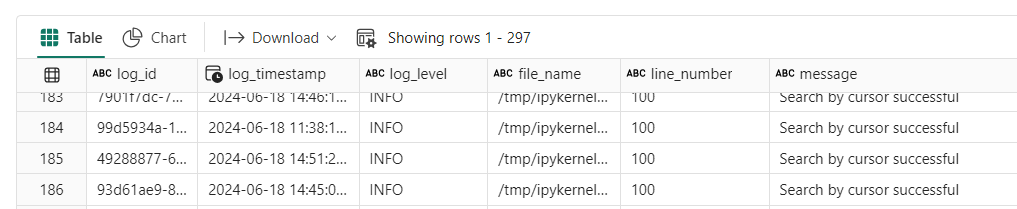
# Schemas
The solution uses three schemas. One for logging, one for the exported data and one for information on last export. The schemas are listed in the code cell below.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, LongType

# Define the log schema
log_schema = StructType([
    StructField("log_id", StringType(), False),
    StructField("log_timestamp", TimestampType(), False),
    StructField("log_level", StringType(), False),
    StructField("file_name", StringType(), False),
    StructField("line_number", StringType(), False),
    StructField("message", StringType(), False)
])

# Define the data schema
schema = StructType([
    StructField("createTime", StringType(), True),
    StructField("kind", StringType(), True),
    StructField("authority", StringType(), True),
    StructField("namespace", StringType(), True),
    StructField("legal", MapType(StringType(), StringType()), True),
    StructField("createUser", StringType(), True),
    StructField("source", StringType(), True),
    StructField("acl", MapType(StringType(), StringType()), True),
    StructField("id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("version", StringType(), True),
    StructField("tags", MapType(StringType(), StringType()), True),
    StructField("data", MapType(StringType(), StringType()), True),
    StructField("modifyUser", StringType(), True),
    StructField("modifyTime", StringType(), True),
    StructField("ancestry", MapType(StringType(), StringType()), True),
    StructField("ingestTime", StringType(), True)
])

run_info_schema = StructType([
    StructField("run_id", StringType(), False),
    StructField("run_timestamp", LongType(), False)
])

# Functions for logging and ADME/OSDU search

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, col
from pyspark.sql.types import TimestampType, StringType, StructType, StructField
import uuid
import requests
from datetime import datetime
import json
from msal import ConfidentialClientApplication
from requests.adapters import HTTPAdapter, Retry
import inspect
import logging

# Define log_message function
def log_message(level, message):
    # Log to console
    if level == "INFO":
        print(f"INFO: {message}")
        logging.info(message)
    elif level == "WARNING":
        print(f"WARNING: {message}")
        logging.warning(message)
    elif level == "ERROR":
        print(f"ERROR: {message}")
        logging.error(message)
    else:
        print(f"DEBUG: {message}")
        logging.debug(message)
    
    # Log to table
    log_id = str(uuid.uuid4())
    frame = inspect.currentframe().f_back
    file_name = frame.f_code.co_filename
    line_number = frame.f_lineno
    log_timestamp = datetime.utcnow()
    
    # Create a DataFrame without current_timestamp()
    log_df = spark.createDataFrame([(log_id, log_timestamp, level, file_name, str(line_number), message)], log_schema)

    # Define the paths for Delta tables
    table_name = config["logging_table"]
    table_path = f"Tables/{table_name}"
    
    # Write the DataFrame to the Delta table
    log_df.write.format("delta").mode("append").save(table_path)

# OSDU search function
def osdu_search_by_cursor(server: str, search_api: str, access_token: str, partition_id: str, query: dict):
    search_api = f"{server}{search_api}query_with_cursor"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "data-partition-id": partition_id,
        "Content-Type": "application/json"
    }

    retry_strategy = Retry(
        total=3,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET", "POST"],
        backoff_factor=1
    )

    session = requests.Session()
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount('http://', adapter)
    session.mount('https://', adapter)

    try:
        response = session.post(search_api, headers=headers, json=query)
        response.raise_for_status()
        json_response = response.json()

        if not json_response or 'results' not in json_response:
            error_message = f"Invalid response content: {json_response}"
            log_message("ERROR", error_message)
            return None

        success_message = "Search by cursor successful"
        logging.info(success_message)
        log_message("INFO", success_message)
        return json_response
    except requests.exceptions.HTTPError as e:
        error_message = f"HTTP Error: {e}, URL: {search_api}"
        log_message("ERROR", error_message)
    except requests.exceptions.ConnectionError as e:
        error_message = f"Connection Error: {e}, URL: {search_api}"
        log_message("ERROR", error_message)
    except requests.exceptions.Timeout as e:
        error_message = f"Timeout Error: {e}, URL: {search_api}"
        log_message("ERROR", error_message)
    except Exception as e:
        error_message = f"Unexpected error: {e}, URL: {search_api}"
        log_message("ERROR", error_message)
    return None


# Authentication

In [ ]:
from msal import ConfidentialClientApplication

# Authentication function
def authenticate_osdu(client_id: str, client_secret: str, authority: str, scopes: list):
    try:
        app = ConfidentialClientApplication(
            client_id=client_id,
            client_credential=client_secret,
            authority=authority
        )

        result = app.acquire_token_for_client(scopes=scopes)
        
        if "access_token" in result:
            message = "Authentication successful"
            log_message("INFO", message)
            return result['access_token']
        else:
            error_message = f"Authentication failed: {result.get('error')}, {result.get('error_description')}"
            log_message("ERROR", error_message)
    except Exception as e:
        error_message = f"Unexpected error during authentication: {e}"
        log_message("ERROR", error_message)
    return None

# Re-authentication function
def re_authenticate():
    key_vault_name = config["key_vault_name"]
    return authenticate_osdu(
        client_id=config['client_id'],
        client_secret=tl.get_secret_with_token(
            f"https://{key_vault_name}.vault.azure.net/",
            config["secret_name"],
            mssparkutils.credentials.getToken(config["access_token_type"])
        ),
        authority=config['authority'],
        scopes=config['scopes']
    )

# Handle potential authentication issues
def handle_authentication_issues(response):
    if response is None or 'results' not in response:
        message = "Initial request failed. Attempting to re-authenticate."
        log_message("INFO", message)
        access_token = re_authenticate()
        if not access_token:
            message = "Re-authentication failed. Unable to proceed."
            log_message("ERROR", message)
            return False, None
    else:
        try:
            process_batch(response)
            cursor = response.get('cursor')
            message = "Initial batch processed and written to the lakehouse."
            log_message("INFO", message)
            return True, cursor
        except Exception as e:
            message = f"Failed to process the initial batch: {e}"
            log_message("ERROR", message)
            return False, None
    return True, cursor



# Authentication token

In [ ]:


key_vault_name = config["key_vault_name"]
access_token = authenticate_osdu(
    client_id = config['client_id'],    
    client_secret= tl.get_secret_with_token(
        f"https://{key_vault_name}.vault.azure.net/",
        config["secret_name"],
        mssparkutils.credentials.getToken(config["access_token_type"])
    ),
    authority= config['authority'],
    scopes= config['scopes']
    
)




# Reset last import time for running code again (testing purposes)

In [ ]:
## Added code Jon Olav Abeland 24.05. This code will create a table to store last run value for delta
## This code can be safely run as it only creates a table if none exists
#from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, lit, unix_timestamp
import uuid
from datetime import datetime

# Initialize Spark session (uncomment if needed)
# spark = SparkSession.builder.appName("ExampleApp").getOrCreate()

lakehouse_name = config["lakehouse_name"]
table_name = f"{lakehouse_name}.run_info"

# SQL to create the table if it doesn't exist
create_table_sql = f"""
CREATE TABLE IF NOT EXISTS {lakehouse_name}.run_info (
    run_id STRING,
    run_timestamp LONG
)
"""

# Execute the SQL to create the table
spark.sql(create_table_sql)

# Clear the table for testing purposes (remove this in production)
spark.sql("DELETE FROM admelakehouse.run_info")

# Define the specific test date
test_run_date = "2024-02-22 00:00:00"

# Insert the test run date as epoch timestamp
run_id = str(uuid.uuid4())
run_info_df = spark.createDataFrame([(run_id,)], ["run_id"])
run_info_df = run_info_df.withColumn("run_timestamp", unix_timestamp(lit(test_run_date)).cast("long"))
#run_info_df.write.insertInto("admelakehouse.run_info", overwrite=False)
run_info_df.write.insertInto(table_name, overwrite=False)

# Query to get the last run value
last_run_df = spark.sql("""
SELECT run_timestamp
FROM admelakehouse.run_info
ORDER BY run_timestamp DESC
LIMIT 1
""")

# Collect the result and extract the timestamp
last_run_timestamp = last_run_df.collect()[0]['run_timestamp']

print(f"Last run timestamp: {last_run_timestamp}")


# Convert epoch time back to human-readable format
human_readable_timestamp = datetime.utcfromtimestamp(last_run_timestamp).strftime('%Y-%m-%d %H:%M:%S')
print(f"Last run timestamp: {human_readable_timestamp}")



# Main code for batch export from ADME/OSDU to Fabric

In [ ]:
from pyspark.sql.functions import current_timestamp, col, to_json, to_timestamp, unix_timestamp
from pyspark.sql.types import TimestampType
from delta.tables import DeltaTable
from datetime import datetime
import uuid
import logging

# Log start of code
log_message("INFO", "Batch export started")

# Define the paths for Delta tables
table_name = config["table_name"]
table_path = f"Tables/{table_name}"

# Query to get the last run value
last_run_df = spark.sql("""
SELECT run_timestamp
FROM admelakehouse.run_info
ORDER BY run_timestamp DESC
LIMIT 1
""")

# Check if the last run timestamp exists
if last_run_df.count() == 0:
    last_run_date = 0  # default to the epoch if no previous run
else:
    last_run_date = last_run_df.collect()[0]['run_timestamp']

log_message("INFO", f"Last run date (epoch): {last_run_date}")
# Convert epoch time back to human-readable format
human_readable_timestamp = datetime.utcfromtimestamp(last_run_date).strftime('%Y-%m-%d %H:%M:%S')
log_message("INFO", f"Last run timestamp: {human_readable_timestamp}")

# Define the initial query
query = {
    "kind": "*:*:*:*",
    "query": f"version:[{last_run_date} TO *]",
    "limit": batch_size
}

def process_batch(response):
    # Create DataFrame from the API response
    df = spark.createDataFrame(response['results'], schema)
    
    # Ensure id column is unique before processing
    unique_df = df.dropDuplicates(["id"])

    # Cast date/time fields to TimestampType
    unique_df = unique_df.withColumn("createTime", to_timestamp(col("createTime"), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")) \
                         .withColumn("modifyTime", to_timestamp(col("modifyTime"), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))

    # Add the 'ingestTime' column with the current timestamp
    unique_df = unique_df.withColumn("ingestTime", current_timestamp())
    
    # Convert complex fields to JSON strings
    unique_df = unique_df.withColumn("legal", to_json(col("legal"))) \
                         .withColumn("acl", to_json(col("acl"))) \
                         .withColumn("tags", to_json(col("tags"))) \
                         .withColumn("data", to_json(col("data"))) \
                         .withColumn("ancestry", to_json(col("ancestry")))

    # Load the Delta table
    table = DeltaTable.forPath(spark, table_path)
    
    # Perform the merge (upsert)
    table.alias("table") \
        .merge(
            unique_df.alias("updates"),
            "table.id = updates.id"
        ) \
        .whenMatchedUpdateAll() \
        .whenNotMatchedInsertAll() \
        .execute()

def make_api_call(query, access_token):
    try:
        response = osdu_search_by_cursor(
            server=config['server'],
            search_api=config['search_url'],
            access_token=access_token,
            partition_id=config['data_partition_id'],
            query=query
        )        
        return response
    except requests.exceptions.RequestException as e:
        log_message("Error", f"Error occurred: {e}")
        if e.response and e.response.status_code == 413:
            log_message("Error", f"Payload Too Large error for query: {json.dumps(query)}")
        return None

# Make initial API call
response = make_api_call(query, access_token)
success, cursor = handle_authentication_issues(response)
if not success:
    raise Exception("Authentication issues could not be resolved.")

# Check if response or response['totalCount'] is None
if response is None or 'totalCount' not in response or response['totalCount'] == 0:
    message = "No documents were found."
    log_message("ERROR", message)
    raise Exception(message)

# Determine the total number of batches
total_iterations = int(response['totalCount'] / batch_size) + (1 if response['totalCount'] % batch_size != 0 else 0)
log_message("INFO", f"Iteration number is {total_iterations}")
log_message("INFO", f"Document number is {response['totalCount']}")

# Start from batch 1
start_batch = 1

# Process subsequent batches
for i in range(start_batch, total_iterations + 1):
    log_message("INFO", f"Processing batch {i}...")
    query["cursor"] = cursor  # Update the cursor in the query
    response = make_api_call(query, access_token)
    if response is None or 'results' not in response:
        log_message("INFO", "Request failed. Attempting to re-authenticate.")
        access_token = re_authenticate()
        if not access_token:
            log_message("ERROR", "Re-authentication failed. Unable to proceed.")
            break
    else:
        try:
            process_batch(response)
            cursor = response.get('cursor')
            log_message("INFO", "Batch processed and written to the lakehouse.")
        except Exception as e:
            log_message("ERROR", f"Failed to process batch {i}: {e}")

# Check the cursor after completing all iterations
if cursor is None:
    log_message("WARNING", "Cursor is None.")
else:
    log_message("WARNING", f"Cursor is NOT None. Cursor number is: {cursor}")

lakehouse_name = config["lakehouse_name"]
spark.sql(f"DELETE FROM {lakehouse_name}.run_info")  # This line ensures there is only one document

# Insert the current timestamp in epoch format
run_id = str(uuid.uuid4())
run_info_df = spark.createDataFrame([(run_id,)], ["run_id"])
run_info_df = run_info_df.withColumn("run_timestamp", unix_timestamp(current_timestamp()))
run_info_df.write.insertInto(f"{lakehouse_name}.run_info", overwrite=False)

# Log end of code
log_message("INFO", "Batch export finished")
